In [1]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple

In [2]:
MINUTES_PER_DAY = 1440
DAYS_PER_WEEK = 7
TOTAL_MINUTES = MINUTES_PER_DAY * DAYS_PER_WEEK  # 10080

STOPS_COUNT = 5
SEGMENT_DURATION = 12  # 12 минут на перегон между соседними станциями => 60 мин = полный круг

NUM_BUSES = 8  # автобусов у нас 8

COST_PER_DRIVER = 200.0
COVERAGE_PENALTY = 50.0
CONFLICT_PENALTY = 30.0
TELEPORT_PENALTY = 5.0
NIGHT_WEEKEND_PENALTY = 10.0
OVERTIME_8H_PENALTY = 5.0
OVERTIME_12H_PENALTY = 5.0


In [3]:
def required_drivers(minute: int) -> int:
    m = minute % MINUTES_PER_DAY
    if (6*60 <= m < 9*60) or (17*60 <= m < 20*60):
        return 4
    elif m >= 22*60 or m < 6*60:
        return 2
    else:
        return 3

In [4]:
class DriverType:
    H8 = "8h"
    H12 = "12h"


In [5]:
def next_stop(stop: int, direction: str) -> int:
    if direction=="CW":
        return (stop+1)%STOPS_COUNT
    else:
        return (stop-1)%STOPS_COUNT

def is_weekend(day: int) -> bool:
    return day>=5

def is_night(min_in_day: int) -> bool:
    return (min_in_day>=22*60 or min_in_day<6*60)

In [6]:
class DriverChromosome:
    def __init__(self, driver_type: str, bus_id: int):
        self.active: bool = True
        self.driver_type: str = driver_type
        self.bus_id: int = bus_id
        self.schedule: List[str] = ["off"]*TOTAL_MINUTES
        self.directions: List[str] = ["CW"]*TOTAL_MINUTES

In [7]:
def create_continuous_8h_block(day: int, sched: List[str]):
    """
    В один конкретный день (day=0..4) создаём ровно 8ч drive непрерывно +1ч break,
    без всяких лишних off. Так автобус сможет точно проехать много станций.
    """
    day_start = day*MINUTES_PER_DAY
    earliest = day_start+6*60
    latest  = day_start+22*60 - 9*60
    if latest<earliest:
        return
    start_local = random.randint(earliest, latest)
    for m in range(start_local, start_local+480):
        sched[m]="drive"
    for m in range(start_local+480, start_local+540):
        if m<TOTAL_MINUTES:
            sched[m]="break"

def create_8h_schedule() -> List[str]:
    """
    Для каждого буднего дня (0..4) создаём один большой 8ч-drive+1ч-break блок
    Выходные (5..6) -> off
    """
    sched = ["off"]*TOTAL_MINUTES
    for day in range(5):
        create_continuous_8h_block(day, sched)
    return sched

def create_continuous_12h_block(day: int, sched: List[str]):
    """
    В 1 день (day) делаем ровно 12ч => 720 мин,
    внутри этого блока = 60 мин break (случайно), остальное drive.
    """
    day_start = day*MINUTES_PER_DAY
    if day_start+720> TOTAL_MINUTES:
        return
    start_local = random.randint(0, MINUTES_PER_DAY-720)
    block_break = set(random.sample(range(720), 60))
    for i in range(720):
        g = day_start+start_local+i
        if g>=TOTAL_MINUTES:
            break
        if i in block_break:
            sched[g]="break"
        else:
            sched[g]="drive"

def create_12h_schedule() -> List[str]:
    """
    2/2 (pattern [1,1,0,0,1,1,0]) = 7 дней.
    Если day=1 => делаем continuous_12h_block
    """
    sched = ["off"]*TOTAL_MINUTES
    pattern=[1,1,0,0,1,1,0]
    for day in range(DAYS_PER_WEEK):
        if pattern[day]==1:
            create_continuous_12h_block(day, sched)
    return sched

def create_random_driver(driver_type: str, bus_id: int) -> DriverChromosome:
    drv = DriverChromosome(driver_type, bus_id)
    if driver_type==DriverType.H8:
        raw = create_8h_schedule()
    else:
        raw = create_12h_schedule()
    drv.schedule=raw[:]
    curr_dir=random.choice(["CW","CCW"])
    for m in range(TOTAL_MINUTES):
        if m==0:
            if drv.schedule[m]=="drive":
                curr_dir=random.choice(["CW","CCW"])
            drv.directions[m]=curr_dir
        else:
            if drv.schedule[m]=="drive":
                if drv.schedule[m-1]!="drive":
                    curr_dir=random.choice(["CW","CCW"])
                drv.directions[m]=curr_dir
            else:
                drv.directions[m]=drv.directions[m-1]
    return drv

In [8]:
def compute_positions(drv: DriverChromosome) -> List[int]:
    pos=[0]*TOTAL_MINUTES
    if not drv.active:
        return pos
    stop=0
    counter=0
    for m in range(TOTAL_MINUTES):
        if drv.schedule[m]=="drive":
            pos[m]=stop
            counter+=1
            if counter>=SEGMENT_DURATION:
                stop=next_stop(stop, drv.directions[m])
                counter=0
        else:
            pos[m]=0
            stop=0
            counter=0
    return pos

In [9]:
def evaluate_individual(indiv: List[DriverChromosome]) -> float:
    penalty=0.0
    active_list=[d for d in indiv if d.active]
    penalty += len(active_list)*COST_PER_DRIVER

    # coverage
    for m in range(TOTAL_MINUTES):
        need=required_drivers(m)
        actual=sum(1 for d in active_list if d.schedule[m]=="drive")
        if actual<need:
            penalty += COVERAGE_PENALTY*(need-actual)

    # conflict bus
    for m in range(TOTAL_MINUTES):
        usage={}
        for d in active_list:
            if d.schedule[m]=="drive":
                usage[d.bus_id]=usage.get(d.bus_id,0)+1
        for b_id,cnt in usage.items():
            if cnt>1:
                penalty += CONFLICT_PENALTY*(cnt-1)

    # positions
    pos_list=[compute_positions(d) for d in indiv]
    for i,drv in enumerate(indiv):
        if not drv.active:
            continue
        pos=pos_list[i]
        # check teleports
        for m in range(TOTAL_MINUTES-1):
            if drv.schedule[m]=="drive" and drv.schedule[m+1]=="drive":
                diff=abs(pos[m+1]-pos[m])
                if diff not in [0,1,4]:
                    penalty+=TELEPORT_PENALTY
    # 8h/12h constraints
    for drv in active_list:
        for day in range(DAYS_PER_WEEK):
            ds=day*MINUTES_PER_DAY
            seg=drv.schedule[ds:ds+MINUTES_PER_DAY]
            drive_count=sum(1 for x in seg if x=="drive")
            break_count=sum(1 for x in seg if x=="break")
            if drv.driver_type=="8h":
                if drive_count>480:
                    penalty+=(drive_count-480)*OVERTIME_8H_PENALTY
                for i,st in enumerate(seg):
                    if st=="drive":
                        if is_weekend(day) or is_night(i):
                            penalty+=NIGHT_WEEKEND_PENALTY
            else:
                if drive_count>720:
                    penalty+=(drive_count-720)*OVERTIME_12H_PENALTY
                if drive_count>0 and break_count<60:
                    penalty+=(60-break_count)
    return penalty


In [10]:
def selection(pop: List[List[DriverChromosome]], fits: List[float]) -> List[List[DriverChromosome]]:
    combo=list(zip(pop,fits))
    combo.sort(key=lambda x:x[1])
    half=len(combo)//2
    return [x[0] for x in combo[:half]]


In [11]:
def crossover(p1: List[DriverChromosome], p2: List[DriverChromosome]) -> Tuple[List[DriverChromosome],List[DriverChromosome]]:
    size=len(p1)
    cut=random.randint(1,size-1)
    c1=[]
    c2=[]
    for i in range(size):
        if i<cut:
            c1.append(p1[i])
            c2.append(p2[i])
        else:
            c1.append(p2[i])
            c2.append(p1[i])
    for i in range(size):
        drv1=c1[i]
        drv2=c2[i]
        if random.random()<0.1:
            tmp=drv1.active
            drv1.active=drv2.active
            drv2.active=tmp
        # одноточечный кросс schedule
        pt=random.randint(1,TOTAL_MINUTES-1)
        s1=drv1.schedule[:]
        d1=drv1.directions[:]
        s2=drv2.schedule[:]
        d2=drv2.directions[:]
        s1[pt:], s2[pt:] = s2[pt:], s1[pt:]
        d1[pt:], d2[pt:] = d2[pt:], d1[pt:]
        drv1.schedule=s1
        drv1.directions=d1
        drv2.schedule=s2
        drv2.directions=d2
    return c1,c2

In [12]:
def repair_driver(drv: DriverChromosome):
    """
    Если inactive => не трогаем.
    Иначе, для 8h убираем drive ночью/выходные.
    """
    if not drv.active:
        return
    curr_dir=drv.directions[0]
    for m in range(TOTAL_MINUTES):
        if m==0:
            if drv.schedule[m]=="drive":
                curr_dir=random.choice(["CW","CCW"])
            drv.directions[m]=curr_dir
        else:
            if drv.schedule[m]=="drive":
                if drv.schedule[m-1]!="drive":
                    curr_dir=random.choice(["CW","CCW"])
                drv.directions[m]=curr_dir
            else:
                drv.directions[m]=drv.directions[m-1]
        if drv.driver_type=="8h":
            day=m//MINUTES_PER_DAY
            minute_in_day=m%MINUTES_PER_DAY
            if drv.schedule[m]=="drive":
                if is_weekend(day) or is_night(minute_in_day):
                    drv.schedule[m]="off"

In [13]:
def mutate(indiv: List[DriverChromosome], mutation_rate: float):
    for drv in indiv:
        if random.random()<0.02:
            drv.active=not drv.active
        # меняем bus_id
        if random.random()<0.01:
            drv.bus_id=random.randint(0, NUM_BUSES-1)

        if not drv.active:
            continue

        # сдвиг больших фрагментов
        if random.random()<0.05:
            length=random.randint(60,240)
            start_i=random.randint(0,TOTAL_MINUTES-length)
            shift=random.randint(-120,120)
            new_sch=drv.schedule[:]
            new_dir=drv.directions[:]
            for j in range(length):
                old_j=start_i+j
                new_j=old_j+shift
                if 0<=new_j<TOTAL_MINUTES:
                    new_sch[new_j] = drv.schedule[old_j]
                    new_dir[new_j] = drv.directions[old_j]
                    new_sch[old_j]="off"
            drv.schedule=new_sch
            drv.directions=new_dir

        # точечная
        for m in range(TOTAL_MINUTES):
            if random.random()<mutation_rate:
                old=drv.schedule[m]
                if old=="drive":
                    if random.random()<0.3:
                        drv.schedule[m]="off"
                    else:
                        drv.schedule[m]="break"
                elif old=="off":
                    if random.random()<0.6:
                        drv.schedule[m]="drive"
                    else:
                        drv.schedule[m]="break"
                else:
                    if random.random()<0.5:
                        drv.schedule[m]="off"
                    else:
                        drv.schedule[m]="drive"
        repair_driver(drv)

In [14]:
def run_ga(
    n_max_drivers: int,
    pop_size: int,
    generations: int,
    mutation_rate: float
):
    """
    Генерация n_max_drivers водителей, у каждого bus_id=random(0..7).
    Ищем оптимальную конфигурацию (k активных, расписания) => мин штраф.
    """
    population=[]
    for _ in range(pop_size):
        indiv=[]
        for i in range(n_max_drivers):
            # 50% 8h, 50% 12h
            tp = DriverType.H8 if (random.random()<0.5) else DriverType.H12
            bus_id = random.randint(0, NUM_BUSES-1)
            d = create_random_driver(tp, bus_id)
            indiv.append(d)
        population.append(indiv)
    best_ind=None
    best_fit=float("inf")
    fit_hist=[]
    for g in range(generations):
        fits=[evaluate_individual(ind) for ind in population]
        for i,f in enumerate(fits):
            if f<best_fit:
                best_fit=f
                best_ind=population[i]
        fit_hist.append(best_fit)
        print(f"Gen {g+1} | Best fit: {best_fit:.2f}")
        combo=list(zip(population,fits))
        combo.sort(key=lambda x:x[1])
        half=len(combo)//2
        selected=[x[0] for x in combo[:half]]
        new_pop=[]
        while len(new_pop)<pop_size:
            p1=random.choice(selected)
            p2=random.choice(selected)
            c1,c2=crossover(p1,p2)
            mutate(c1, mutation_rate)
            mutate(c2, mutation_rate)
            new_pop.append(c1)
            if len(new_pop)<pop_size:
                new_pop.append(c2)
        population=new_pop
    return best_ind,best_fit,fit_hist

In [15]:
def build_schedule_table(indiv: List[DriverChromosome]) -> pd.DataFrame:
    idx_labels=[]
    for m in range(TOTAL_MINUTES):
        day=m//MINUTES_PER_DAY
        d_m=m%MINUTES_PER_DAY
        hh=d_m//60
        mm=d_m%60
        idx_labels.append(f"Day{day+1} {hh:02d}:{mm:02d}")

    columns=[]
    pos_list = [compute_positions(d) for d in indiv]
    for i,d in enumerate(indiv):
        lab_active = "A" if d.active else "X"
        columns.append(f"Drv{i+1}_{d.driver_type}_{lab_active}(bus={d.bus_id})")
    data={c:[] for c in columns}
    for m in range(TOTAL_MINUTES):
        for i,drv in enumerate(indiv):
            col=columns[i]
            if not drv.active:
                data[col].append("inactive")
                continue
            st=drv.schedule[m]
            p=pos_list[i][m]
            if st=="drive":
                if p==0:
                    data[col].append("drive(depot)")
                else:
                    data[col].append(f"drive(stop={p})")
            elif st=="break":
                data[col].append("break(depot)")
            else:
                data[col].append("off(depot)")
    return pd.DataFrame(data, index=idx_labels)

Gen 1 | Best fit: 1547080.00
Gen 2 | Best fit: 1410379.00
Gen 3 | Best fit: 1247315.00
Gen 4 | Best fit: 1065001.00
Gen 5 | Best fit: 864527.00
Gen 6 | Best fit: 718160.00
Gen 7 | Best fit: 718160.00
Gen 8 | Best fit: 705115.00
Gen 9 | Best fit: 698930.00
Gen 10 | Best fit: 644475.00
Gen 11 | Best fit: 557370.00
Gen 12 | Best fit: 557370.00
Gen 13 | Best fit: 557370.00
Gen 14 | Best fit: 557370.00
Gen 15 | Best fit: 557370.00
Gen 16 | Best fit: 557370.00
Gen 17 | Best fit: 557370.00
Gen 18 | Best fit: 444980.00
Gen 19 | Best fit: 439500.00
Gen 20 | Best fit: 439500.00
Gen 21 | Best fit: 439500.00
Gen 22 | Best fit: 416245.00
Gen 23 | Best fit: 416245.00
Gen 24 | Best fit: 369310.00
Gen 25 | Best fit: 369310.00
Gen 26 | Best fit: 369310.00
Gen 27 | Best fit: 369310.00
Gen 28 | Best fit: 330010.00
Gen 29 | Best fit: 330010.00
Gen 30 | Best fit: 330010.00
Gen 31 | Best fit: 330010.00
Gen 32 | Best fit: 330010.00
Gen 33 | Best fit: 330010.00
Gen 34 | Best fit: 330010.00
Gen 35 | Best fit: 

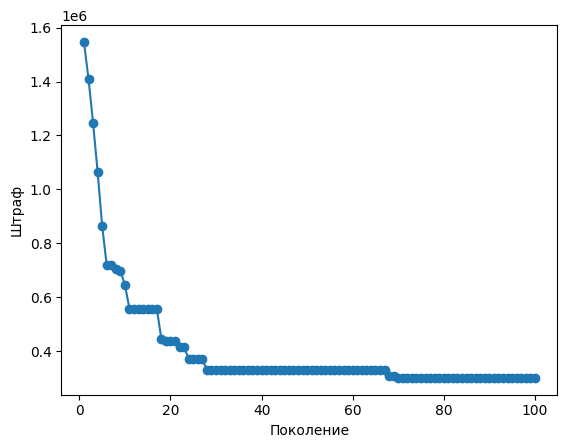

In [16]:
def print_stats(indiv: List[DriverChromosome]):
    act_count = sum(d.active for d in indiv)
    print(f"Всего водителей: {len(indiv)}, Активных: {act_count}")
    n8=sum(1 for d in indiv if d.active and d.driver_type=="8h")
    n12=sum(1 for d in indiv if d.active and d.driver_type=="12h")
    print(f"Среди активных: 8h={n8}, 12h={n12}")
    used_buses=set(d.bus_id for d in indiv if d.active)
    print(f"Используемые автобусы: {used_buses}")

if __name__=="__main__":
    # Предположим, мы хотим 12 потенциальных водителей, 8 автобусов (bus_id = random(0..7))
    # Запустим ГА: pop_size=10, generations=15
    n_max_drivers=30
    pop_size=10
    generations=100
    mutation_rate=0.01
    best_ind, best_fit, hist= run_ga(n_max_drivers,pop_size,generations,mutation_rate)
    print(f"Лучший фитнес: {best_fit:.2f}")
    print_stats(best_ind)
    df = build_schedule_table(best_ind)
    # Посмотрим первые 60 строк
    print(df.head(60))
    plt.plot(range(1,len(hist)+1), hist, marker='o')
    plt.xlabel("Поколение")
    plt.ylabel("Штраф")
    plt.show()
